<a href="https://colab.research.google.com/github/braianrzzz/CMLS-HW2/blob/master/HW1_Group14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1 - Computer Music (Valence and Arousal)


###**Setup**

In [0]:
import numpy as np
import librosa, librosa.display
import os
import matplotlib.pyplot as plt
import sklearn.svm
import IPython.display as ipd
import scipy as sp
import pandas as pd
import csv
import seaborn as seabornInstance
import seaborn as sns

In [13]:
!wget --no-check-certificate -r "https://drive.google.com/u/0/uc?id=10CfTAIlhD1bWER1temxNYcda7lfNupt3&export=download" -O "annotations.zip"

will be placed in the single file you specified.

--2020-05-16 18:14:00--  https://drive.google.com/u/0/uc?id=10CfTAIlhD1bWER1temxNYcda7lfNupt3&export=download
Resolving drive.google.com (drive.google.com)... 64.233.189.113, 64.233.189.102, 64.233.189.100, ...
Connecting to drive.google.com (drive.google.com)|64.233.189.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-48-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4a36dcdogusf1e25lu76c75p08g17v7b/1589652825000/18317275537345979741/*/10CfTAIlhD1bWER1temxNYcda7lfNupt3?e=download [following]
--2020-05-16 18:14:20--  https://doc-0s-48-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4a36dcdogusf1e25lu76c75p08g17v7b/1589652825000/18317275537345979741/*/10CfTAIlhD1bWER1temxNYcda7lfNupt3?e=download
Resolving doc-0s-48-docs.googleusercontent.com (doc-0s-48-docs.googleusercontent.com)... 64.233.188.132, 2404:6800:4008:c06::84
Conn

In [14]:
!wget --no-check-certificate -r "https://drive.google.com/uc?id=12MCAyfZxquIK-dkmOX3Mi9AC2SBSJ2bG&export=download" -O "MEMD_audio.zip" 

will be placed in the single file you specified.

--2020-05-16 18:14:54--  https://drive.google.com/uc?id=12MCAyfZxquIK-dkmOX3Mi9AC2SBSJ2bG&export=download
Resolving drive.google.com (drive.google.com)... 108.177.125.102, 108.177.125.100, 108.177.125.138, ...
Connecting to drive.google.com (drive.google.com)|108.177.125.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘MEMD_audio.zip’

MEMD_audio.zip          [ <=>                ]   3.18K  --.-KB/s    in 0s      

2020-05-16 18:14:54 (39.6 MB/s) - ‘MEMD_audio.zip’ saved [3252]

Loading robots.txt; please ignore errors.
--2020-05-16 18:14:54--  https://drive.google.com/robots.txt
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘MEMD_audio.zip’

MEMD_audio.zip          [ <=>                ]     570  --.-KB/s    in 0s      

2020-05-16 18:14:54 (81.4 MB/s) - ‘MEMD_audio.zip’ save

In [15]:
!unzip annotations.zip

Archive:  annotations.zip
replace annotations/annotations averaged per song/dynamic (per second annotations)/valence.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [16]:
!unzip MEMD_audio.zip

Archive:  MEMD_audio.zip
warning [MEMD_audio.zip]:  405157 extra bytes at beginning or within zipfile
  (attempting to process anyway)
replace 746.mp3? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


###**Features extraction**

In [0]:
# get dataframe from annotations file
annotations = pd.read_csv('/content/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv')

In [0]:
#Divide the 4 labels
annot1 = annotations[' valence_mean'].values
annot2 = annotations[' valence_std'].values
annot3 = annotations[' arousal_mean'].values
annot4 = annotations[' arousal_std'].values

In [0]:
#Sonogram and total loudness
fft_window_size=1024
fs = 44100
freq_axis = float(fs)/fft_window_size * np.arange(0,(fft_window_size/2) + 1)
M=(0.023)*fs

# border definitions of the 24 critical bands of hearing
bark = [100,   200,  300,  400,  510,  630,   770,   920, 
        1080, 1270, 1480, 1720, 2000, 2320,  2700,  3150,
        3700, 4400, 5300, 6400, 7700, 9500, 12000, 15500]

eq_loudness = np.array(
    [[ 55,   40,  32,  24,  19,  14, 10,  6,  4,  3,  2,  
        2,    0,  -2,  -5,  -4,   0,  5, 10, 14, 25, 35], 
     [ 66,   52,  43,  37,  32,  27, 23, 21, 20, 20, 20,  
       20,   19,  16,  13,  13,  18, 22, 25, 30, 40, 50], 
     [ 76,   64,  57,  51,  47,  43, 41, 41, 40, 40, 40,
     39.5, 38,  35,  33,  33,  35, 41, 46, 50, 60, 70], 
     [ 89,   79,  74,  70,  66,  63, 61, 60, 60, 60, 60,  
       59,   56,  53,  52,  53,  56, 61, 65, 70, 80, 90], 
     [103,   96,  92,  88,  85,  83, 81, 80, 80, 80, 80,  
       79,   76,  72,  70,  70,  75, 79, 83, 87, 95,105], 
     [118,  110, 107, 105, 103, 102,101,100,100,100,100,  
       99,   97,  94,  90,  90,  95,100,103,105,108,115]])

loudn_freq = np.array(
    [31.62,   50,  70.7,   100, 141.4,   200, 316.2,  500, 
     707.1, 1000,  1414,  1682,  2000,  2515,  3162, 3976,
     5000,  7071, 10000, 11890, 14140, 15500])

# calculate bark-filterbank
loudn_bark = np.zeros((eq_loudness.shape[0], len(bark)))

i = 0
j = 0

for bsi in bark:

    while j < len(loudn_freq) and bsi > loudn_freq[j]:
        j += 1
    
    j -= 1
    
    if np.where(loudn_freq == bsi)[0].size != 0: # loudness value for this frequency already exists
        loudn_bark[:,i] = eq_loudness[:,np.where(loudn_freq == bsi)][:,0,0]
    else:
        w1 = 1 / np.abs(loudn_freq[j] - bsi)
        w2 = 1 / np.abs(loudn_freq[j + 1] - bsi)
        loudn_bark[:,i] = (eq_loudness[:,j]*w1 + eq_loudness[:,j+1]*w2) / (w1 + w2)
    
    i += 1

In [0]:
def compute_sonogram(audio,fs,m_fft):
   # Compute the spectrogram of the audio signal
    X = np.abs(librosa.stft(
        audio,
        window='hamming',
        n_fft=1024,
        hop_length=int(m_fft//2),)
        )
    
    #shape into the bark scale
    matrix = np.zeros((len(bark),X.shape[1]))

    barks = bark[:]
    barks.insert(0,0)

    for i in range(len(barks)-1):
      matrix[i] = np.sum(X[((freq_axis >= barks[i]) & (freq_axis < barks[i+1]))], axis=0)
    matrix[np.where(matrix < 1)] = 1

    #scale to decibel

    matrix = 10 * np.log10(matrix)

    #scale to sone

    idx     = np.where(matrix >= 40)
    not_idx = np.where(matrix < 40)

    matrix[idx]     =  2**((matrix[idx]-40)/10)
    matrix[not_idx] =  (matrix[not_idx]/40)**2.642

    return matrix


In [0]:
def total_loudness(sone,n_audio_f):
  other=np.zeros([24,n_audio_f])
  tl=np.zeros(n_audio_f)
  for i in range(n_audio_f):
    max_f=np.argmax(sone[:,i])
    for n in range(24):
      if n!=max_f:
        other[n,i]=sone[n,i]*0.15
    tl[i]=sone[max_f,i]+np.sum(other[:,i])
  return tl

In [31]:
#Create headers for csv file of features
header = 'song rolloff_mean rolloff_std zero_crossing_rate_mean zero_crossing_rate_std spectral_centroid_mean spectral_centroid_std spectral_bandwidth_mean spectral_bandwidth_std onset_mean onset_std tempo'
for i in range(1, 14):
    header += f' mfcc{i}_mean mfcc{i}_std'

header += ' tot_loudness_mean tot_loudness_std'

for k in range(0, 24):
    header += f' SONE_mean{k} SONE_std{k}'

header = header.split()

#Create file .csv with headers
file = open('features_mean-std.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)


#SORTING THE AUDIO FILES
array_str1=[]
for i in np.arange(2,2000):
  array_str1.append(str(i)+".mp3")

audio_root = '/content/' 
class_audio_files = [f for f in os.listdir(audio_root) if f in array_str1]
n_audio_samples1 = len(class_audio_files)

a1=class_audio_files
for i in np.arange(0,n_audio_samples1):
  for j in range(0, n_audio_samples1-i-1):
    b1=a1[j]
    c1=a1[j+1]
    if int(b1[:-4]) > int(c1[:-4]) :
      a1[j], a1[j+1] = a1[j+1], a1[j]

class_audio_files=a1 

#compute features
for index, f in enumerate(class_audio_files): 
    audio, fs = librosa.load(os.path.join(audio_root, f), sr=None)
    roll = librosa.feature.spectral_rolloff(audio, sr=fs, S=None, n_fft=1024, hop_length=512, freq=None, roll_percent=0.85) # roll-out  method
    zcr =  librosa.feature.zero_crossing_rate(audio, frame_length=1024, hop_length=512, center=True) # zero crossing rate method
    cent = librosa.feature.spectral_centroid(y=audio, sr=fs, S=None, n_fft=1024, hop_length=512) # spectral centroid method
    bw = librosa.feature.spectral_bandwidth(y=audio, sr=fs)# spectral bandwidth method
    onset_st = librosa.onset.onset_strength(audio,fs) # onset strenght method
    bpm = librosa.beat.tempo(audio, fs) # tempo method
    mfcc = librosa.feature.mfcc(y=audio, sr=fs, S=None, n_mfcc=13, dct_type=2, norm='ortho') # MFCCs method
    n_audio_frames = int((len(audio)-fft_window_size)/int(M//2))+1;
    sonogram = compute_sonogram(audio,fs,M) #Sonogram
    tot_laud = total_loudness(sonogram,n_audio_frames)
    to_append = f'{f} {np.mean(roll)} {np.std(roll)} {np.mean(zcr)} {np.std(zcr)} {np.mean(cent)} {np.std(cent)} {np.mean(bw)} {np.std(bw)} {np.mean(onset_st)} {np.std(onset_st)} {np.mean(bpm)}' 
   
    for e in mfcc:
            to_append += f' {np.mean(e)} {np.std(e)}'
    
    to_append += f' {np.mean(tot_laud)} {np.std(tot_laud)}'

    for p in sonogram:
            to_append += f' {np.mean(p)} {np.std(p)}'
    
#Write features in the same file of headers in the same order as well
    file = open('features_mean-std.csv', 'a', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(to_append.split())

                  

/usr/local/lib/python3.6/dist-packages/librosa/beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
/usr/local/lib/python3.6/dist-packages/librosa/beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


In [0]:
#Add the labels in the .csv and put them into an array  
features_file = pd.read_csv('/content/features_mean-std.csv')
features_file_mod = features_file.drop(columns=[' valence_mean', ' valence_std', ' arousal_mean', ' arousal_std'])
feat_array = np.array(features_file_mod)

###**Linear Regression**

#### Normalize for Linear Regression

In [0]:
#Normalize X (Features)

#Normalize X (All Features)
t_ft_max = np.max(feat_array, axis=0)
t_ft_min = np.min(feat_array, axis=0)
feat_array_norm = (feat_array - t_ft_min) / (t_ft_max - t_ft_min)
X_l = feat_array_norm
X_l_df = pd.DataFrame(X_l)

#Normalize Y (Annotations)

#Normalize valence_mean
t_an_max = np.max(annot1, axis=0)
t_an_min = np.min(annot1, axis=0)
annot_norm = (annot1 - t_an_min) / (t_an_max - t_an_min)
y = annot_norm

#Normalize valence_std
t_an_max = np.max(annot2, axis=0)
t_an_min = np.min(annot2, axis=0)
annot_norm2 = (annot2 - t_an_min) / (t_an_max - t_an_min)
y2 = annot_norm2

#Normalize arousal_mean
t_an_max = np.max(annot3, axis=0)
t_an_min = np.min(annot3, axis=0)
annot_norm3 = (annot3 - t_an_min) / (t_an_max - t_an_min)
y3 = annot_norm3

#Normalize arousal_std
t_an_max = np.max(annot4, axis=0)
t_an_min = np.min(annot4, axis=0)
annot_norm4 = (annot4 - t_an_min) / (t_an_max - t_an_min)
y4 = annot_norm4



#### SelectKBest parameters


In [0]:
#Select the features with the SelectKBest function our K is 88 selecting all the columns of our csv file, here is where we tried our different values of k comparing the selections with our pearson correlation table
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=88)
X_ln = selector.fit_transform(X_l, y)
vector_names = list(features_file_mod.columns[selector.get_support(indices=True)])
print(f" For Valance_mean:\n{vector_names}")

X_ln2 = selector.fit_transform(X_l, y2)
vector_names = list(features_file_mod.columns[selector.get_support(indices=True)])
print(f"\n For Valance_std:\n{vector_names}")

X_ln3 = selector.fit_transform(X_l, y3)
vector_names = list(features_file_mod.columns[selector.get_support(indices=True)])
print(f"\n For Arousal_mean:\n{vector_names}")

X_ln4 = selector.fit_transform(X_l, y4)
vector_names = list(features_file_mod.columns[selector.get_support(indices=True)])
print(f"\n For Arousal_std:\n{vector_names}")


 For Valance_mean:
['song', 'rolloff_mean', 'rolloff_std', 'zero_crossing_rate_mean', 'zero_crossing_rate_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_bandwidth_mean', 'spectral_bandwidth_std', 'onset_mean', 'onset_std', 'tempo', 'mfcc1_mean', 'mfcc1_std', 'mfcc2_mean', 'mfcc2_std', 'mfcc3_mean', 'mfcc3_std', 'mfcc4_mean', 'mfcc4_std', 'mfcc5_mean', 'mfcc5_std', 'mfcc6_mean', 'mfcc6_std', 'mfcc7_mean', 'mfcc7_std', 'mfcc8_mean', 'mfcc_std', 'mfcc9_mean', 'mfcc9_std', 'mfcc10_mean', 'mfcc10_std', 'mfcc11_mean', 'mfcc11_std', 'mfcc12_mean', 'mfcc12_std', 'mfcc13_mean', 'mfcc13_std', 'tot_loudness_mean', 'tot_loudness_std', 'SONE_mean0', 'SONE_mean1', 'SONE_mean2', 'SONE_mean3', 'SONE_mean4', 'SONE_mean5', 'SONE_mean6', 'SONE_mean7', 'SONE_mean8', 'SONE_mean9', 'SONE_mean10', 'SONE_mean11', 'SONE_mean12', 'SONE_mean13', 'SONE_mean14', 'SONE_mean15', 'SONE_mean16', 'SONE_mean17', 'SONE_mean18', 'SONE_mean19', 'SONE_mean20', 'SONE_mean21', 'SONE_mean22', 'SONE_mean23',

#### Train/test split (Hold-out) for Linear Regression



In [0]:
#We left this option as an example for us in case we needed to use it in different situations
"""
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ln, y, test_size=0.2, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_ln2, y2, test_size=0.2, random_state=0)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_ln3, y3, test_size=0.2, random_state=0)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_ln4, y4, test_size=0.2, random_state=0)
"""

'\nfrom sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split(X_ln, y, test_size=0.2, random_state=0)\nX_train2, X_test2, y_train2, y_test2 = train_test_split(X_ln2, y2, test_size=0.2, random_state=0)\nX_train3, X_test3, y_train3, y_test3 = train_test_split(X_ln3, y3, test_size=0.2, random_state=0)\nX_train4, X_test4, y_train4, y_test4 = train_test_split(X_ln4, y4, test_size=0.2, random_state=0)\n'

#### K-Fold Cross Validation for Linear Regression

In [0]:
#Applied the cross validation of 10 splits
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, random_state=42, shuffle=True)
for train_index, test_index in cv.split(X_ln):
    X_train, X_test, y_train, y_test = X_ln[train_index], X_ln[test_index], y[train_index], y[test_index]

for train_index, test_index in cv.split(X_ln2):
    X_train2, X_test2, y_train2, y_test2 = X_ln2[train_index], X_ln2[test_index], y2[train_index], y2[test_index]

for train_index, test_index in cv.split(X_ln3):
    X_train3, X_test3, y_train3, y_test3 = X_ln3[train_index], X_ln3[test_index], y3[train_index], y3[test_index]

for train_index, test_index in cv.split(X_ln4):
    X_train4, X_test4, y_train4, y_test4 = X_ln4[train_index], X_ln4[test_index], y4[train_index], y4[test_index]


#### Training and Prediction for Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression 
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

regressor2 = LinearRegression()  
regressor2.fit(X_train2, y_train2)

regressor3 = LinearRegression()  
regressor3.fit(X_train3, y_train3)

regressor4 = LinearRegression()  
regressor4.fit(X_train4, y_train4)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_pred = regressor.predict(X_test)
y_pred2 = regressor2.predict(X_test2)
y_pred3 = regressor3.predict(X_test3)
y_pred4 = regressor4.predict(X_test4)

#### Results for Linear Regression

In [0]:
#Compute metrics 
def compute_metrics(y_tested,y_predicted):
  mse = sklearn.metrics.mean_squared_error(y_tested, y_predicted)
  r2 = sklearn.metrics.r2_score(y_tested, y_predicted)
  print("Results : \n MSE = {:.5f} \n R2 = {:.5f} \n".format(mse, r2))

In [0]:
print('Valence_mean')
compute_metrics(y_test,y_pred)
print('Valence_std')
compute_metrics(y_test2,y_pred2)
print('Arousal_mean')
compute_metrics(y_test3,y_pred3)
print('Arousal_std')
compute_metrics(y_test4,y_pred4)

Valence_mean
Results : 
 MSE = 0.01538 
 R2 = 0.53183 

Valence_std
Results : 
 MSE = 0.02498 
 R2 = 0.04185 

Arousal_mean
Results : 
 MSE = 0.01780 
 R2 = 0.59381 

Arousal_std
Results : 
 MSE = 0.03651 
 R2 = -0.06264 



###**Support Vector Regression**

#### Standarization for Support Vector Regression

In [0]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_svr_s = sc_X.fit_transform(feat_array)
Y_42 = sc_y.fit_transform(annotations)
Y = Y_42[:,1] #Select valence_mean as Y
Y2 = Y_42[:,2] #Select valence_std as Y2
Y3 = Y_42[:,3] #Select arousal_mean as Y3
Y4 = Y_42[:,4] #Select arousal_std as Y4 

#### SelectKBest parameters

In [0]:
#Features selection with SelectKBest Function
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=88)
X_svr = selector.fit_transform(X_svr_s, Y)
vector_names = list(features_file_mod.columns[selector.get_support(indices=True)])
print(f" For Valence_mean:\n{vector_names}")

X_svr2 = selector.fit_transform(X_svr_s, Y2)
vector_names = list(features_file_mod.columns[selector.get_support(indices=True)])
print(f"\n For Valence_std:\n{vector_names}")

X_svr3 = selector.fit_transform(X_svr_s, Y3)
vector_names = list(features_file_mod.columns[selector.get_support(indices=True)])
print(f"\n For Arousal_mean:\n{vector_names}")

X_svr4 = selector.fit_transform(X_svr_s, Y4)
vector_names = list(features_file_mod.columns[selector.get_support(indices=True)])
print(f"\n For Arousal_std:\n{vector_names}")


 For Valance_mean:
['song', 'rolloff_mean', 'rolloff_std', 'zero_crossing_rate_mean', 'zero_crossing_rate_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_bandwidth_mean', 'spectral_bandwidth_std', 'onset_mean', 'onset_std', 'tempo', 'mfcc1_mean', 'mfcc1_std', 'mfcc2_mean', 'mfcc2_std', 'mfcc3_mean', 'mfcc3_std', 'mfcc4_mean', 'mfcc4_std', 'mfcc5_mean', 'mfcc5_std', 'mfcc6_mean', 'mfcc6_std', 'mfcc7_mean', 'mfcc7_std', 'mfcc8_mean', 'mfcc_std', 'mfcc9_mean', 'mfcc9_std', 'mfcc10_mean', 'mfcc10_std', 'mfcc11_mean', 'mfcc11_std', 'mfcc12_mean', 'mfcc12_std', 'mfcc13_mean', 'mfcc13_std', 'tot_loudness_mean', 'tot_loudness_std', 'SONE_mean0', 'SONE_mean1', 'SONE_mean2', 'SONE_mean3', 'SONE_mean4', 'SONE_mean5', 'SONE_mean6', 'SONE_mean7', 'SONE_mean8', 'SONE_mean9', 'SONE_mean10', 'SONE_mean11', 'SONE_mean12', 'SONE_mean13', 'SONE_mean14', 'SONE_mean15', 'SONE_mean16', 'SONE_mean17', 'SONE_mean18', 'SONE_mean19', 'SONE_mean20', 'SONE_mean21', 'SONE_mean22', 'SONE_mean23',

#### Train/test split (Hold-out) for Support Vector Regression


In [0]:
#We left this option as an example for us in case we needed to use it in different situations
"""
from sklearn.model_selection import train_test_split
X_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(X_svr, Y, test_size=0.2, random_state=0)
X_train_svr2, X_test_svr2, y_train_svr2, y_test_svr2 = train_test_split(X_svr2, Y2, test_size=0.2, random_state=0)
X_train_svr3, X_test_svr3, y_train_svr3, y_test_svr3 = train_test_split(X_svr3, Y3, test_size=0.2, random_state=0)
X_train_svr4, X_test_svr4, y_train_svr4, y_test_svr4 = train_test_split(X_svr4, Y4, test_size=0.2, random_state=0)
"""

'\nfrom sklearn.model_selection import train_test_split\nX_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(X_svr, Y, test_size=0.2, random_state=0)\nX_train_svr2, X_test_svr2, y_train_svr2, y_test_svr2 = train_test_split(X_svr2, Y2, test_size=0.2, random_state=0)\nX_train_svr3, X_test_svr3, y_train_svr3, y_test_svr3 = train_test_split(X_svr3, Y3, test_size=0.2, random_state=0)\nX_train_svr4, X_test_svr4, y_train_svr4, y_test_svr4 = train_test_split(X_svr4, Y4, test_size=0.2, random_state=0)\n'

#### K-Fold Cross Validation for Support Vector Regression

In [0]:
#Applied the cross validation of 10 splits
cv = KFold(n_splits=10, random_state=42, shuffle=True)
for train_index, test_index in cv.split(X_svr):
    X_train_svr, X_test_svr, y_train_svr, y_test_svr = X_svr[train_index], X_svr[test_index], Y[train_index], Y[test_index]

for train_index, test_index in cv.split(X_svr2):
    X_train_svr2, X_test_svr2, y_train_svr2, y_test_svr2 = X_svr2[train_index], X_svr2[test_index], Y2[train_index], Y2[test_index]

for train_index, test_index in cv.split(X_svr3):
    X_train_svr3, X_test_svr3, y_train_svr3, y_test_svr3 = X_svr3[train_index], X_svr3[test_index], Y3[train_index], Y3[test_index]

for train_index, test_index in cv.split(X_svr4):
    X_train_svr4, X_test_svr4, y_train_svr4, y_test_svr4 = X_svr4[train_index], X_svr4[test_index], Y4[train_index], Y4[test_index]


#### Training and Prediction for Support Vector Regression

In [0]:
#Training 
from sklearn.svm import SVR
SupportVectorRegModel = SVR()
SupportVectorRegModel.fit(X_train_svr, y_train_svr)

SupportVectorRegModel2 = SVR()
SupportVectorRegModel2.fit(X_train_svr2, y_train_svr2)

SupportVectorRegModel3 = SVR()
SupportVectorRegModel3.fit(X_train_svr3, y_train_svr3)

SupportVectorRegModel4 = SVR()
SupportVectorRegModel4.fit(X_train_svr4, y_train_svr4)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
#Prediction
y_pred_svr = SupportVectorRegModel.predict(X_test_svr)
y_pred_svr2 = SupportVectorRegModel2.predict(X_test_svr2)
y_pred_svr3 = SupportVectorRegModel3.predict(X_test_svr3)
y_pred_svr4 = SupportVectorRegModel4.predict(X_test_svr4)

#### Results for Support Vector Regression

In [0]:
print('Valence_mean')
compute_metrics(y_test_svr,y_pred_svr)
print('Valence_std')
compute_metrics(y_test_svr2,y_pred_svr2)
print('Arousal_mean')
compute_metrics(y_test_svr3,y_pred_svr3)
print('Arousal_std')
compute_metrics(y_test_svr4,y_pred_svr4)

Valence_mean
Results : 
 MSE = 0.53700 
 R2 = 0.51315 

Valence_std
Results : 
 MSE = 1.18060 
 R2 = 0.00494 

Arousal_mean
Results : 
 MSE = 0.42796 
 R2 = 0.61605 

Arousal_std
Results : 
 MSE = 1.25915 
 R2 = -0.08864 



###**Plots and Features Correlation**

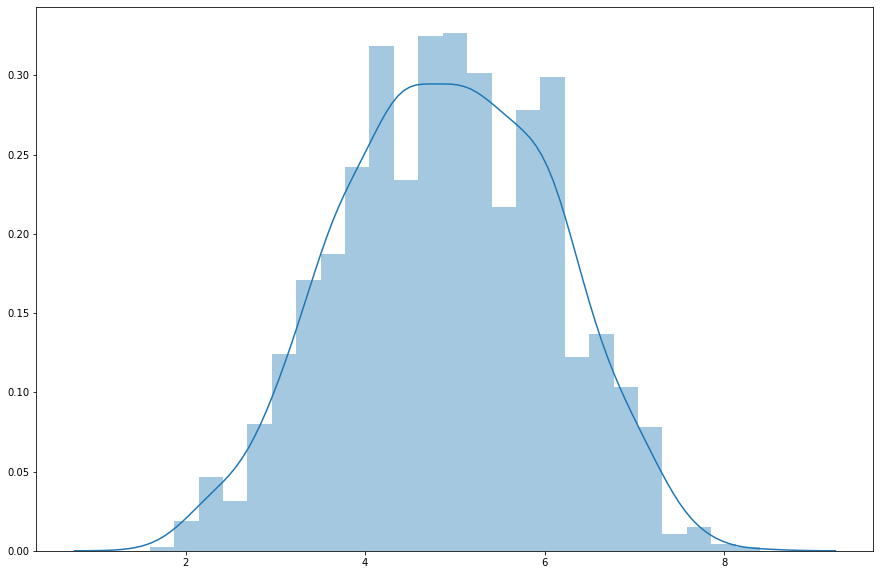

In [0]:
#Plot the annotations of valence mean in order to visualize the distribution of our y data 
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(annot1)

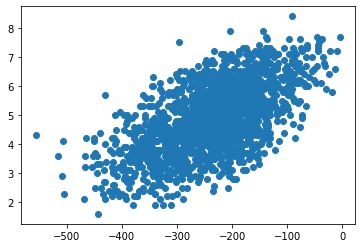

In [0]:
#plot the behaviour of our x values vs y values, in here we analyze one by one those features that had not so much correlation and those ones with best correlation 
plt.plot(features_file.loc[:,'mfcc1_mean'], annotations.loc[:, ' valence_mean'], 'o')   
plt.show()

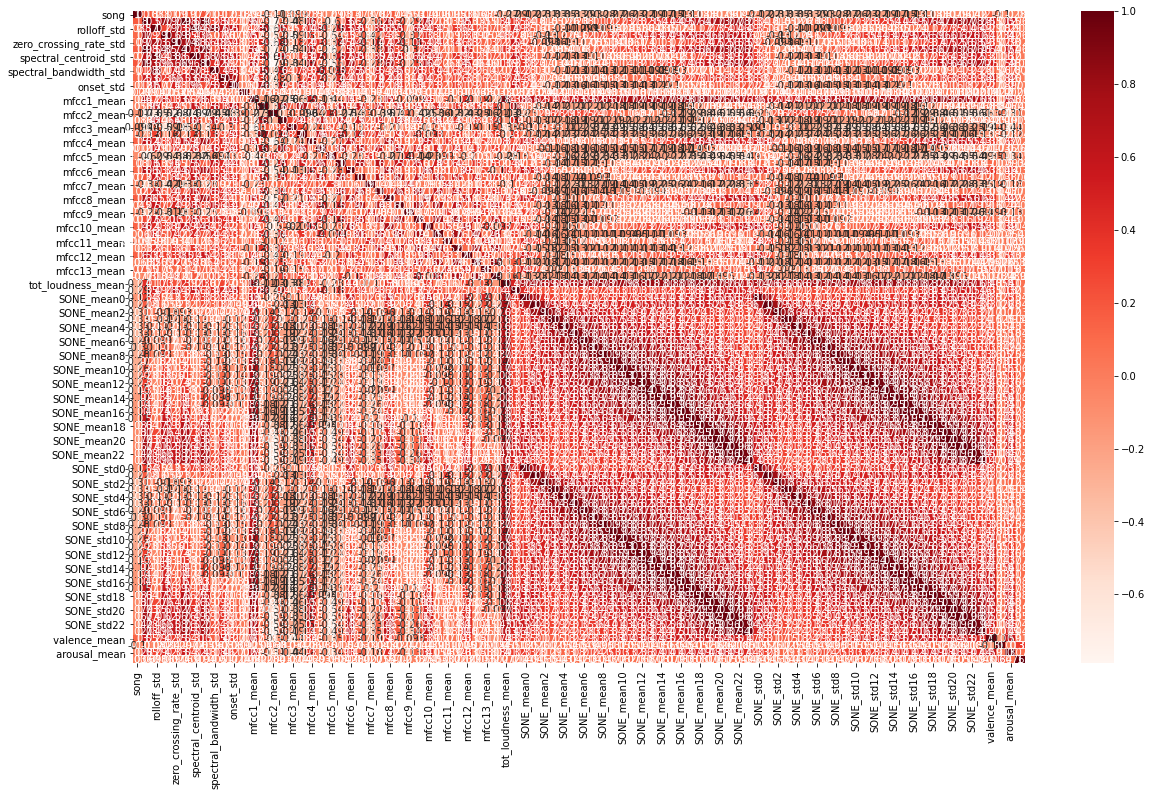

In [0]:
#Using Pearson Correlation
database = features_file
plt.figure(figsize=(20,12))
cor = database.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [0]:
#Correlations with output variables
cor_target = abs(cor[" valence_mean"])
cor_target2 = abs(cor[" valence_std"])
cor_target3 = abs(cor[" arousal_mean"])
cor_target4 = abs(cor[" arousal_std"])
#Selecting highly correlated features
relevant_feat = cor_target[cor_target>0.5]
relevant_feat2 = cor_target2[cor_target2>0.5]
relevant_feat3 = cor_target3[cor_target3>0.5]
relevant_feat4 = cor_target4[cor_target4>0.5]
print('  Valence_mean : \n\n{}\n\n  Valence_std : \n\n{}\n\n  Arousal_mean : \n\n{}\n\n  Arousal_std : \n\n{}'.format(relevant_feat, relevant_feat2, relevant_feat3, relevant_feat4))

  Valence_mean : 

rolloff_mean              0.545632
spectral_centroid_mean    0.539344
mfcc1_mean                0.611100
SONE_mean15               0.517057
SONE_mean16               0.522490
SONE_mean17               0.547946
SONE_mean18               0.551780
SONE_mean19               0.549063
SONE_mean20               0.543752
SONE_mean21               0.532626
SONE_mean22               0.510537
SONE_std15                0.517057
SONE_std16                0.522490
SONE_std17                0.547946
SONE_std18                0.551780
SONE_std19                0.549063
SONE_std20                0.543752
SONE_std21                0.532626
SONE_std22                0.510537
 valence_mean             1.000000
 arousal_mean             0.588053
Name:  valence_mean, dtype: float64

  Valence_std : 

 valence_std    1.0
Name:  valence_std, dtype: float64

  Arousal_mean : 

rolloff_mean              0.553496
spectral_centroid_mean    0.541374
mfcc1_mean                0.578877
 valence_me

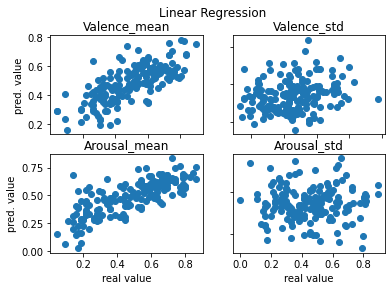

In [0]:
#Plots showing the predicted values and the ones from annotations (linear regression)
fig, axs = plt.subplots(2, 2)
fig.suptitle('Linear Regression')
axs[0, 0].plot(y_test, y_pred, 'o') 
axs[0, 0].set_title('Valence_mean')
axs[0, 1].plot(y_test2, y_pred2, 'o') 
axs[0, 1].set_title('Valence_std')
axs[1, 0].plot(y_test3, y_pred3, 'o') 
axs[1, 0].set_title('Arousal_mean')
axs[1, 1].plot(y_test4, y_pred4, 'o') 
axs[1, 1].set_title('Arousal_std')

for ax in axs.flat:
    ax.set(xlabel='real value', ylabel='pred. value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

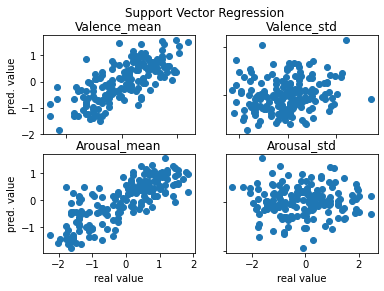

In [0]:
#Plots showing the predicted values and the ones from annotations (Support vector regression)
fig, axs = plt.subplots(2, 2)
fig.suptitle('Support Vector Regression')
axs[0, 0].plot(y_test_svr, y_pred_svr, 'o') 
axs[0, 0].set_title('Valence_mean')
axs[0, 1].plot(y_test_svr2, y_pred_svr2, 'o') 
axs[0, 1].set_title('Valence_std')
axs[1, 0].plot(y_test_svr3, y_pred_svr3, 'o') 
axs[1, 0].set_title('Arousal_mean')
axs[1, 1].plot(y_test_svr4, y_pred_svr4, 'o') 
axs[1, 1].set_title('Arousal_std')

for ax in axs.flat:
    ax.set(xlabel='real value', ylabel='pred. value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

###**SVR using cross_val_predict**

In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVR
SupportVectorRegModel = SVR()

y_pred_svr = cross_val_predict(SupportVectorRegModel, X_svr, Y, cv=20)
y_pred_svr2 = cross_val_predict(SupportVectorRegModel, X_svr2, Y2, cv=20)
y_pred_svr3 = cross_val_predict(SupportVectorRegModel, X_svr3, Y3, cv=20)
y_pred_svr4 = cross_val_predict(SupportVectorRegModel, X_svr4, Y4, cv=20)

In [0]:
#Results
print('Valence_mean')
compute_metrics(Y,y_pred_svr)
print('Valence_std')
compute_metrics(Y2,y_pred_svr2)
print('Arousal_mean')
compute_metrics(Y3,y_pred_svr3)
print('Arousal_std')
compute_metrics(Y4,y_pred_svr4)

Valence_mean
Results : 
 MSE = 0.47861 
 R2 = 0.52139 

Valence_std
Results : 
 MSE = 1.01107 
 R2 = -0.01107 

Arousal_mean
Results : 
 MSE = 0.46023 
 R2 = 0.53977 

Arousal_std
Results : 
 MSE = 1.07896 
 R2 = -0.07896 



###**SVR using cross_val_score**

In [0]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.svm import SVR
SupportVectorRegModel = SVR()

cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

y_pred = cross_val_score(SupportVectorRegModel, X_svr, Y, cv=cv)
y_pred2 = cross_val_score(SupportVectorRegModel, X_svr2, Y2, cv=cv)
y_pred3 = cross_val_score(SupportVectorRegModel, X_svr3, Y3, cv=cv)
y_pred4 = cross_val_score(SupportVectorRegModel, X_svr4, Y4, cv=cv)

In [0]:
y_pred_mse = cross_val_score(regressor, X_svr, Y, scoring='neg_mean_squared_error', cv=cv)
y_pred_mse2 = cross_val_score(regressor, X_svr2, Y2, scoring='neg_mean_squared_error', cv=cv)
y_pred_mse3 = cross_val_score(regressor, X_svr3, Y3, scoring='neg_mean_squared_error', cv=cv)
y_pred_mse4 = cross_val_score(regressor, X_svr4, Y4, scoring='neg_mean_squared_error', cv=cv)

In [0]:
#Results
print("Valence_mean \nResults :\n MSE = %0.5f \n R2 = %0.5f" % (abs(y_pred_mse.mean()), y_pred.mean()))
print("\nValence_std \nResults :\n MSE = %0.5f \n R2 = %0.5f" % (abs(y_pred_mse2.mean()), y_pred2.mean()))
print("\nArousal_mean \nResults :\n MSE = %0.5f \n R2 = %0.5f" % (abs(y_pred_mse3.mean()), y_pred3.mean()))
print("\nArousal_std \nResults :\n MSE = %0.5f \n R2 = %0.5f" % (abs(y_pred_mse4.mean()), y_pred4.mean()))

Valence_mean 
Results :
 MSE = 0.52071 
 R2 = 0.52805

Valence_std 
Results :
 MSE = 1.06942 
 R2 = -0.00111

Arousal_mean 
Results :
 MSE = 0.53672 
 R2 = 0.56795

Arousal_std 
Results :
 MSE = 1.14308 
 R2 = -0.06865


###**Linear Regression using cross_val_predict**

In [0]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.linear_model import LinearRegression 
regressor = LinearRegression()  

y_pred = cross_val_predict(regressor, X_ln, y, cv=20)
y_pred2 = cross_val_predict(regressor, X_ln, y2, cv=20)
y_pred3 = cross_val_predict(regressor, X_ln, y3, cv=20)
y_pred4 = cross_val_predict(regressor, X_ln, y4, cv=20)

In [0]:
#Results
print('Valence_mean')
compute_metrics(y,y_pred)
print('Valence_std')
compute_metrics(y2,y_pred2)
print('Arousal_mean')
compute_metrics(y3,y_pred3)
print('Arousal_std')
compute_metrics(y4,y_pred4)

Valence_mean
Results : 
 MSE = 0.01561 
 R2 = 0.47582 

Valence_std
Results : 
 MSE = 0.03028 
 R2 = -0.37799 

Arousal_mean
Results : 
 MSE = 0.02097 
 R2 = 0.46686 

Arousal_std
Results : 
 MSE = 0.03516 
 R2 = -0.18390 



###**Linear Regression using cross_val_score**

In [0]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.linear_model import LinearRegression 
regressor = LinearRegression()  
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

y_pred = cross_val_score(regressor, X_ln, y, cv=cv)
y_pred2 = cross_val_score(regressor, X_ln, y2, cv=cv)
y_pred3 = cross_val_score(regressor, X_ln, y3, cv=cv)
y_pred4 = cross_val_score(regressor, X_ln, y4, cv=cv)

In [0]:
y_pred_mse = cross_val_score(regressor, X_ln, y, scoring='neg_mean_squared_error', cv=cv)
y_pred_mse2 = cross_val_score(regressor, X_ln, y2, scoring='neg_mean_squared_error', cv=cv)
y_pred_mse3 = cross_val_score(regressor, X_ln, y3, scoring='neg_mean_squared_error', cv=cv)
y_pred_mse4 = cross_val_score(regressor, X_ln, y4, scoring='neg_mean_squared_error', cv=cv)

In [0]:
#Results
print("Valence_mean \nResults :\n MSE = %0.5f \n R2 = %0.5f" % (abs(y_pred_mse.mean()), y_pred.mean()))
print("\nValence_std \nResults :\n MSE = %0.5f \n R2 = %0.5f" % (abs(y_pred_mse2.mean()), y_pred2.mean()))
print("\nArousal_mean \nResults :\n MSE = %0.5f \n R2 = %0.5f" % (abs(y_pred_mse3.mean()), y_pred3.mean()))
print("\nArousal_std \nResults :\n MSE = %0.5f \n R2 = %0.5f" % (abs(y_pred_mse4.mean()), y_pred4.mean()))

Valence_mean 
Results :
 MSE = 0.01683 
 R2 = 0.43539

Valence_std 
Results :
 MSE = 0.02368 
 R2 = -0.06360

Arousal_mean 
Results :
 MSE = 0.02115 
 R2 = 0.46595

Arousal_std 
Results :
 MSE = 0.03319 
 R2 = -0.11609
